In [1]:
!pip install pystan==2.19.1.1
!pip install prophet

In [1]:
import os
import glob
import csv
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge

from darts.metrics import mae
from darts.metrics import mse
from darts.metrics import rmse

import random
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.plot import add_changepoints_to_plot
import datetime

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler

In [2]:
def interpolate_method(df,column_name,methode,direction,order,limit):
  df[column_name] = df[column_name].interpolate(method=methode,limit_direction = direction,order=order,limit=limit)
  return df

def clean_csv(df,time_variable,quantitative_variable):
  df = df[[time_variable, quantitative_variable]].copy()
  df.columns = ['ds','y']
  df['y'] = (df['y'].apply(pd.to_numeric, errors='coerce')).to_frame()
  df = df.drop_duplicates(subset=['ds'])
  df['ds'] = pd.to_datetime(df.ds, errors = 'coerce')
  df = df.dropna(subset=['ds'])
  df = df.sort_values(by=['ds'])
  pourcentage = ((len(df) - df['y'].count()) / len(df)) * 100
  if (pourcentage <= 2):
    df = df.dropna(subset=['y'])
  elif((pourcentage > 2) and (pourcentage < 25)):
    df = interpolate_method(df,'y',"polynomial",None,2,None)
  elif((pourcentage >= 25)):
    print("La base de donnée comporte un grand nombre de données manquantes pour être étudiée.")
  if(len(df) > 1000):
      supr = len(df) - 1000
      df = df[:-supr]
  return df, pourcentage

In [3]:
def naive_method(df):
  if len(df.columns) > 2:
    print("Erreur : il y a plus d'une seule variable")
  elif(len(df) < 500):
      print("Erreur : le data frame est trop petit")
  else:
    n = len(df)
    period = 300
    train_len = n-period
    train = df[0:train_len]
    val = df[train_len:]
    
    series = TimeSeries.from_dataframe(df, 'ds', 'y')
    train_scaled = TimeSeries.from_dataframe(train, 'ds', 'y')
    val_scaled = TimeSeries.from_dataframe(val, 'ds', 'y')
    
    scaler = Scaler()
    train_scaled = scaler.fit_transform(train_scaled)
    val_scaled = scaler.transform(val_scaled)
    series_scaled = scaler.transform(series)
        
    y_hat_naive = val.copy()
    y_hat_naive['naive_forecast'] = train['y'][train_len-1]
    
    y_hat_naive_scaled = TimeSeries.from_dataframe(y_hat_naive, 'ds', 'naive_forecast')
    y_hat_naive_scaled = scaler.transform(y_hat_naive_scaled)
    
    MAE = mae(val_scaled,y_hat_naive_scaled)
    MSE = mse(val_scaled,y_hat_naive_scaled)
    RMSE = rmse(val_scaled,y_hat_naive_scaled)


    return(train_scaled, val_scaled, y_hat_naive_scaled, MAE, MSE, RMSE)

In [4]:
def prophet_model(df,frequency):
  if len(df.columns) > 2:
    print("Erreur : il y a plus d'une seule variable")
  elif(len(df) < 500):
    print("Erreur : le data frame est trop petit")
  else:
    n = len(df)
    period = 300
    df_fit = df[:-period]
    df_true = df[n-period:]
    
    series = TimeSeries.from_dataframe(df, 'ds', 'y')
    train = TimeSeries.from_dataframe(df_fit, 'ds', 'y')
    val = TimeSeries.from_dataframe(df_true, 'ds', 'y')
    
    scaler = Scaler()
    train_scaled = scaler.fit_transform(train)
    val_scaled = scaler.transform(val)
    series_scaled = scaler.transform(series)
    
    m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality = True)
    m.fit(df_fit)
    future = m.make_future_dataframe(periods=period*2, freq=frequency)
    if (frequency == 'M'):
        for i in range (n-period, len(future)):
            future['ds'][i] = future['ds'][i] + datetime.timedelta(days=1)
    forecast = m.predict(future)
    df_true_prediction = pd.merge(df_true, forecast, how ='inner', on =['ds'])
    df_true_prediction = df_true_prediction[['ds', 'y', 'yhat', 'yhat_upper', 'yhat_lower']].copy()
    
    pred = TimeSeries.from_dataframe(df_true_prediction, 'ds', 'yhat')
    pred_scaled = scaler.transform(pred)
    
    MAE = mae(val_scaled,pred_scaled)
    MSE = mse(val_scaled,pred_scaled)
    RMSE = rmse(val_scaled, pred_scaled)
    
    return(train_scaled, val_scaled, pred_scaled, MAE, MSE, RMSE)

In [5]:
os.getcwd()

'/home/nazim/MAIN4/Transformers/Code/700-300'

In [6]:
os.chdir('../../Datasets/Données_Démographiques')
os.getcwd()

'/home/nazim/MAIN4/Transformers/Datasets/Données_Démographiques'

In [7]:
!ls

D-dep_02.csv  D-dep_08.csv  D-dep-77.csv  D-dep-92.csv
D-dep_04.csv  D-dep_09.csv  D-dep-78.csv  D-dep-93.csv
D-dep_06.csv  D-dep-74.csv  D-dep-90.csv  D-dep-94.csv
D-dep_07.csv  D-dep-75.csv  D-dep-91.csv  D-dep-95.csv


In [8]:
def predict():
    file_name = []
    df = []
    pourcentage = []

    df_fit_naive = []
    df_true_prediction_naive = []
    forecast_naive = []

    df_fit_prophet = []
    df_true_prediction_prophet = []
    forecast_prophet = []

    results_naive = pd.DataFrame(columns=['DATA_SET_NAME','Method','MAE','MSE','RMSE'])
    results_prophet = pd.DataFrame(columns=['DATA_SET_NAME','Method','MAE','MSE','RMSE'])

    i = 0
    for files in glob.glob("*.csv"):
        file_name.append(Path(files).stem)
        print(file_name[i])
        df_not_cleaned = pd.read_csv(files)
        df_clean, pourcentage_actual = clean_csv(df_not_cleaned, "Date","Value")
        df.append(df_clean)
        pourcentage.append(pourcentage_actual)

        df_fit_temp_naive , df_true_prediction_temp_naive , forecast_temp_naive , MAE_naive, MSE_naive, RMSE_naive = naive_method(df[i])
        df_fit_naive.append(df_fit_temp_naive)
        df_true_prediction_naive.append(df_true_prediction_temp_naive)
        forecast_naive.append(forecast_temp_naive)

        df_fit_temp_prophet , df_true_prediction_temp_prophet , forecast_temp_prophet , MAE_prophet, MSE_prophet, RMSE_prophet = prophet_model(df[i],file_name[i][0])
        df_fit_prophet.append(df_fit_temp_prophet)
        df_true_prediction_prophet.append(df_true_prediction_temp_prophet)
        forecast_prophet.append(forecast_temp_prophet)

        df_new_row_naive = pd.DataFrame(data=np.array([[file_name[i],'Naive Method',MAE_naive,MSE_naive,RMSE_naive]]), columns=['DATA_SET_NAME','Method','MAE','MSE','RMSE'])
        df_new_row_prophet = pd.DataFrame(data=np.array([[file_name[i],'Prophet Method',MAE_prophet,MSE_prophet,RMSE_prophet]]), columns=['DATA_SET_NAME','Method','MAE','MSE','RMSE'])
        results_naive = pd.concat([results_naive,df_new_row_naive], ignore_index=True)
        results_prophet = pd.concat([results_prophet,df_new_row_prophet], ignore_index=True)
        i = i +1

    return file_name,df, pourcentage, df_fit_naive, df_true_prediction_naive, forecast_naive, results_naive, df_fit_prophet, df_true_prediction_prophet, forecast_prophet, results_prophet

In [9]:
file_name, df, pourcentage, df_fit_naive, df_true_prediction_naive, forecast_naive, results_naive, df_fit_prophet, df_true_prediction_prophet, forecast_prophet, results_prophet = predict()

D-dep-93
Initial log joint probability = -6.42589
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1390.67    0.00331586       97.5672     0.06197           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100        1390.7    0.00115071       150.351   1.179e-05       0.001      165  LS failed, Hessian reset 
     183          1391    9.0145e-08       85.2964      0.2451           1      275   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
D-dep_02
Initial log joint probability = -8.80813
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1219.59   4.94396e-05       65.7236      0.3751      0.3751      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     165       1219.61   2.98665e-06       86.8856   3

Initial log joint probability = -20.5663
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1120.99   0.000103312       99.2934      0.6969      0.6969      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134          1121   4.72619e-08       89.4959           1           1      171   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
D-dep_08
Initial log joint probability = -17.1309
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       943.259   6.15999e-07       80.9723      0.3123      0.3123      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       943.259   5.72525e-06       92.8094   6.231e-08       0.001      200  LS failed, Hessian reset 
     146        943.26   8.38175e-08       87.0395           1 

In [10]:
df

[            ds   y
 0   2019-01-01  19
 1   2019-01-02  35
 2   2019-01-03  20
 3   2019-01-04  27
 4   2019-01-05  29
 ..         ...  ..
 995 2021-09-22  16
 996 2021-09-23  20
 997 2021-09-24  21
 998 2021-09-25  20
 999 2021-09-26  19
 
 [1000 rows x 2 columns],
             ds   y
 0   2019-01-01  19
 1   2019-01-02  19
 2   2019-01-03  16
 3   2019-01-04  16
 4   2019-01-05  20
 ..         ...  ..
 995 2021-09-22  14
 996 2021-09-23  14
 997 2021-09-24   9
 998 2021-09-25  12
 999 2021-09-26  20
 
 [1000 rows x 2 columns],
             ds   y
 0   2019-01-01  29
 1   2019-01-02  30
 2   2019-01-03  15
 3   2019-01-04  20
 4   2019-01-05  28
 ..         ...  ..
 995 2021-09-22  18
 996 2021-09-23  19
 997 2021-09-24  21
 998 2021-09-25  24
 999 2021-09-26  19
 
 [1000 rows x 2 columns],
             ds   y
 0   2019-01-01  23
 1   2019-01-02  19
 2   2019-01-03  28
 3   2019-01-04  23
 4   2019-01-05  32
 ..         ...  ..
 995 2021-09-22  22
 996 2021-09-23  23
 997 2021-09-24 

In [11]:
results_naive

,DATA_SET_NAME,Method,MAE,MSE,RMSE
0,D-dep-93,Naive Method,0.053814102564102566,0.004435096153846154,0.06659651758047229
1,D-dep_02,Naive Method,0.11016666666666666,0.019150000000000004,0.1383835250309805
2,D-dep-91,Naive Method,0.13417777777777776,0.023342814814814813,0.15278355544630715
3,D-dep-95,Naive Method,0.09214285714285711,0.012222448979591833,0.11055518522254772
4,D-dep-78,Naive Method,0.09939814814814814,0.014601980452674895,0.12083865462953026
5,D-dep_09,Naive Method,0.22355555555555554,0.06595555555555556,0.256818137123443
6,D-dep-94,Naive Method,0.051887905604719765,0.004391625551465789,0.0662693409614566
7,D-dep-74,Naive Method,0.15962962962962965,0.032263374485596706,0.17962008374788357
8,D-dep_06,Naive Method,0.25544871794871793,0.08646572978303747,0.2940505565086342
9,D-dep_04,Naive Method,0.1708888888888889,0.04217777777777777,0.20537229067665816


In [12]:
results_prophet

,DATA_SET_NAME,Method,MAE,MSE,RMSE
0,D-dep-93,Prophet Method,0.056143211300250566,0.005444571848423399,0.07378734206097547
1,D-dep_02,Prophet Method,0.09421211910115158,0.014941767522551318,0.1222365228667411
2,D-dep-91,Prophet Method,0.07407435617230403,0.009397502198756454,0.0969407148661307
3,D-dep-95,Prophet Method,0.09375419908234285,0.024055182763055648,0.1550973331913081
4,D-dep-78,Prophet Method,0.08390252956771041,0.012429580928543252,0.1114880304272313
5,D-dep_09,Prophet Method,0.13433894038815683,0.028946020627749553,0.17013530094530516
6,D-dep-94,Prophet Method,0.053599686181506824,0.005524486605452982,0.07432689019091934
7,D-dep-74,Prophet Method,0.33887113456780005,0.13212705533087715,0.36349285458022024
8,D-dep_06,Prophet Method,0.12498968400183207,0.02507679598073637,0.15835654700938756
9,D-dep_04,Prophet Method,0.14344016771468943,0.032277970677333186,0.1796607098876468


In [13]:
results_prophet.to_csv(r'../../Resultats/Resultats_300/prophet_results_demog.csv', index = False)
results_naive.to_csv(r'../../Resultats/Resultats_300/naive_results_demog.csv', index = False)

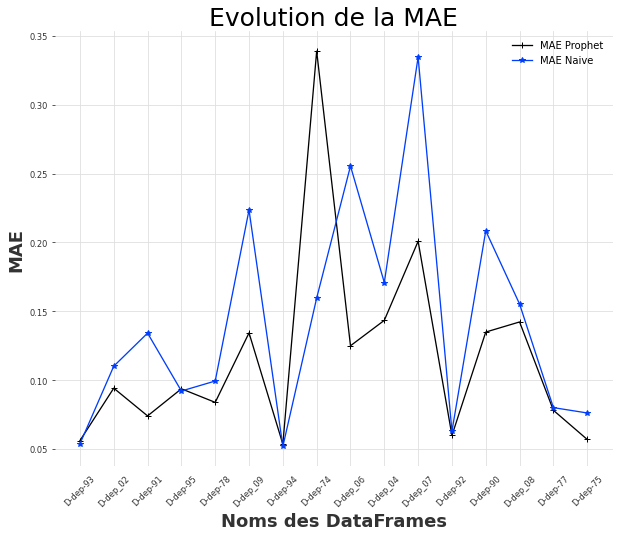

In [14]:
figure(figsize=(10, 8))
plt.axes()

liste_MAE1_prophet = results_prophet["MAE"].tolist()
liste_MAE_prophet = [float(item) for item in liste_MAE1_prophet]

liste_MAE1_naive = results_naive["MAE"].tolist()
liste_MAE_naive = [float(item) for item in liste_MAE1_naive]

x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
y = np.array(liste_MAE_prophet)
y2 = np.array(liste_MAE_naive)

liste_NAME = results_prophet["DATA_SET_NAME"].tolist()
my_xticks = liste_NAME
plt.xticks(x, my_xticks)
plt.xticks(rotation=45)
plt.plot(x, y, label = 'MAE Prophet', marker="+")
plt.plot(x, y2, label = 'MAE Naive', marker="*")
plt.title("Evolution de la MAE",fontsize=25)
plt.xlabel("Noms des DataFrames",fontsize=18)
plt.ylabel("MAE",fontsize=18)
plt.legend()
plt.show()

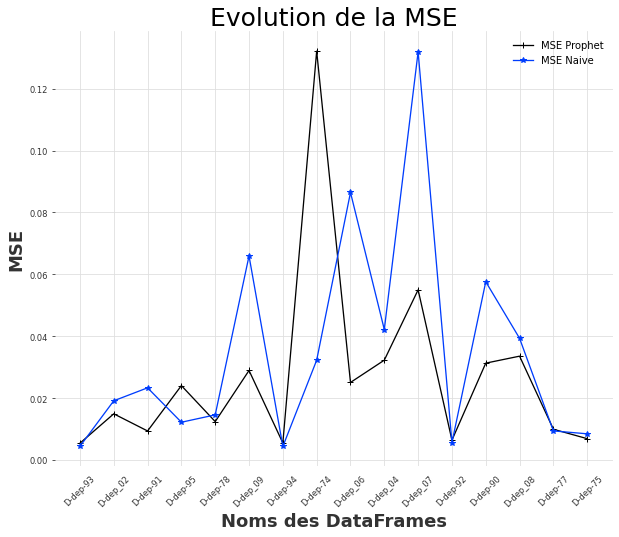

In [15]:
figure(figsize=(10, 8))
plt.axes()

liste_MSE1_prophet = results_prophet["MSE"].tolist()
liste_MSE_prophet = [float(item) for item in liste_MSE1_prophet]

liste_MSE1_naive = results_naive["MSE"].tolist()
liste_MSE_naive = [float(item) for item in liste_MSE1_naive]

x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
y = np.array(liste_MSE_prophet)
y2 = np.array(liste_MSE_naive)

liste_NAME = results_prophet["DATA_SET_NAME"].tolist()
my_xticks = liste_NAME
plt.xticks(x, my_xticks)
plt.xticks(rotation=45)
plt.plot(x, y, label = 'MSE Prophet', marker="+")
plt.plot(x, y2, label = 'MSE Naive', marker="*")
plt.title("Evolution de la MSE",fontsize=25)
plt.xlabel("Noms des DataFrames",fontsize=18)
plt.ylabel("MSE",fontsize=18)
plt.legend()
plt.show()

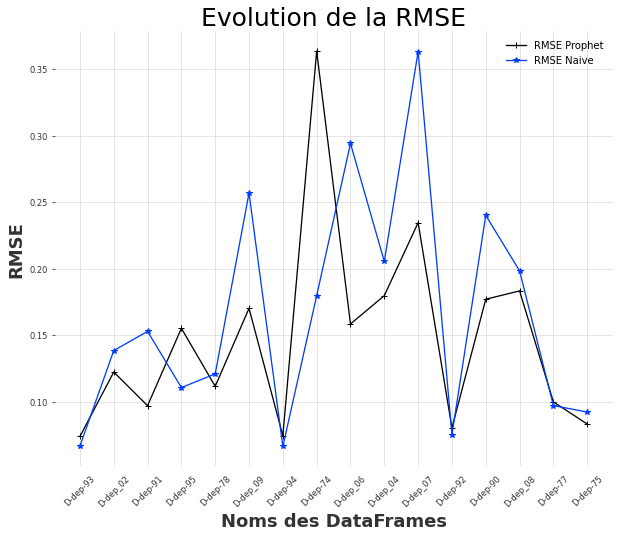

In [16]:
figure(figsize=(10, 8))
plt.axes()

liste_RMSE1_prophet = results_prophet["RMSE"].tolist()
liste_RMSE_prophet = [float(item) for item in liste_RMSE1_prophet]

liste_RMSE1_naive = results_naive["RMSE"].tolist()
liste_RMSE_naive = [float(item) for item in liste_RMSE1_naive]

x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
y = np.array(liste_RMSE_prophet)
y2 = np.array(liste_RMSE_naive)

liste_NAME = results_prophet["DATA_SET_NAME"].tolist()
my_xticks = liste_NAME
plt.xticks(x, my_xticks)
plt.xticks(rotation=45)
plt.plot(x, y, label = 'RMSE Prophet', marker="+")
plt.plot(x, y2, label = 'RMSE Naive', marker="*")
plt.title("Evolution de la RMSE",fontsize=25)
plt.xlabel("Noms des DataFrames",fontsize=18)
plt.ylabel("RMSE",fontsize=18)
plt.legend()
plt.show()

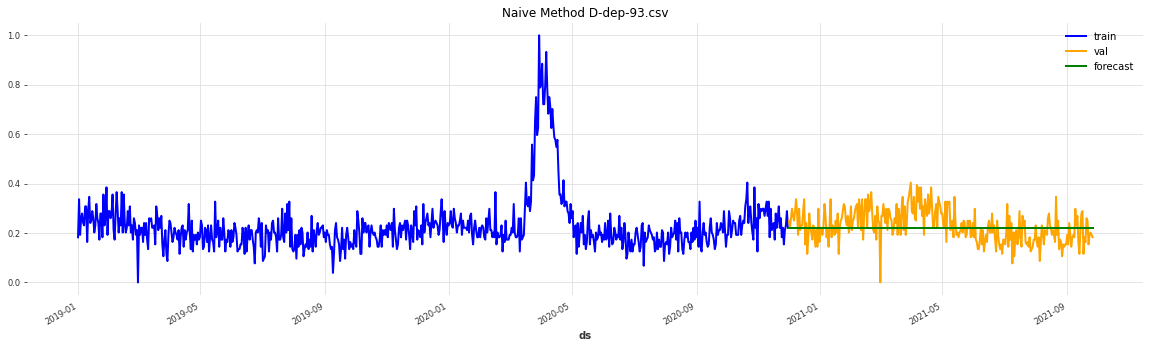

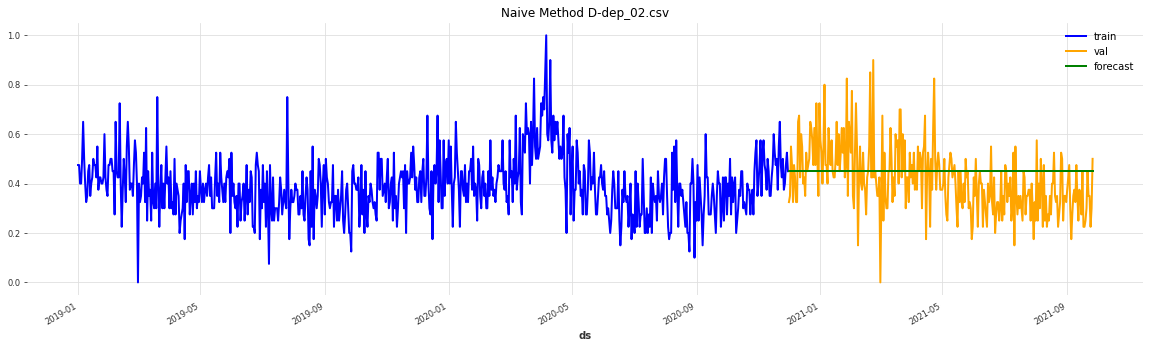

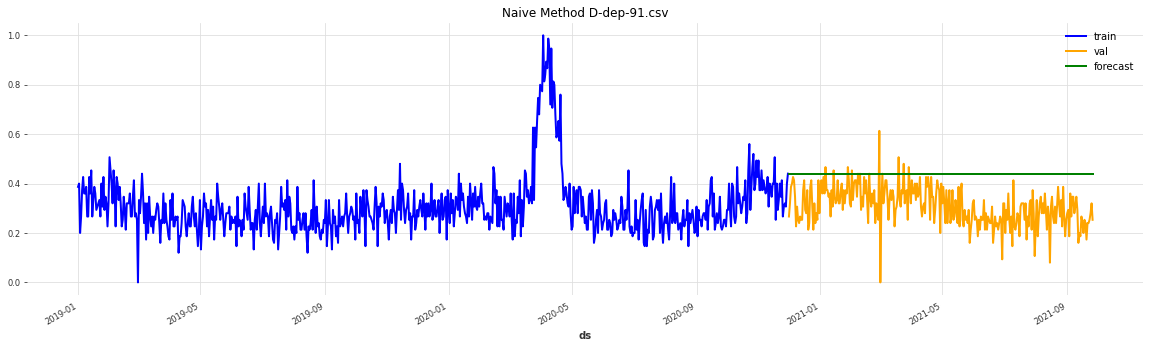

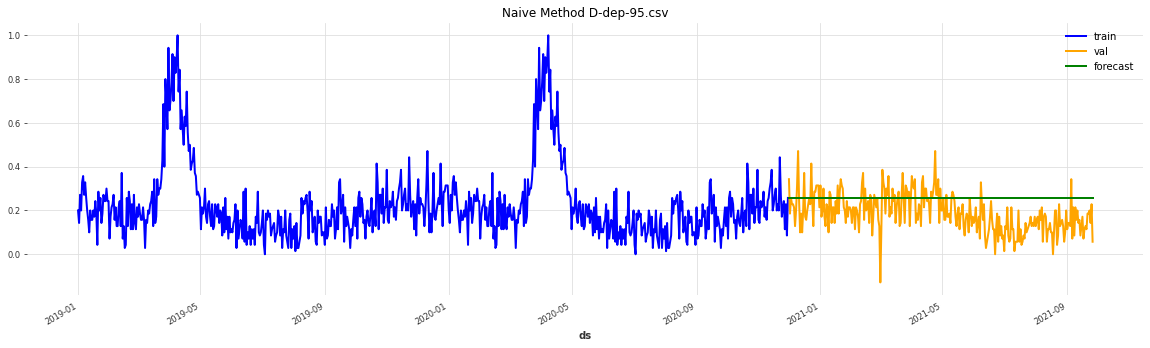

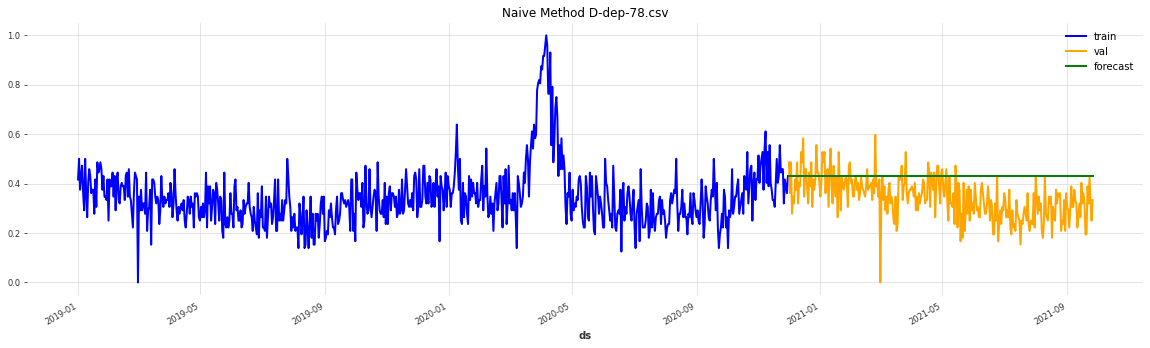

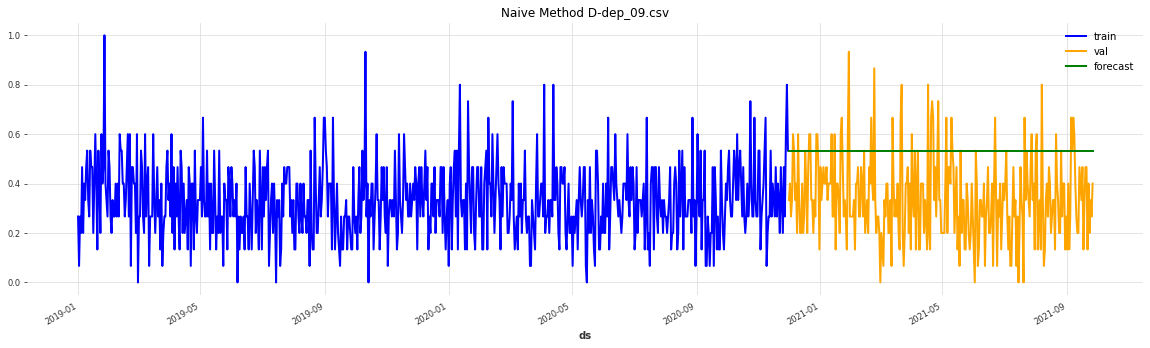

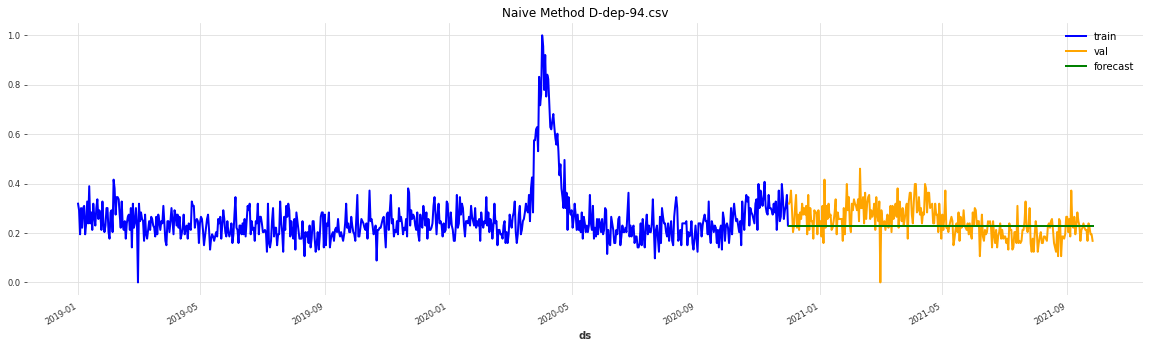

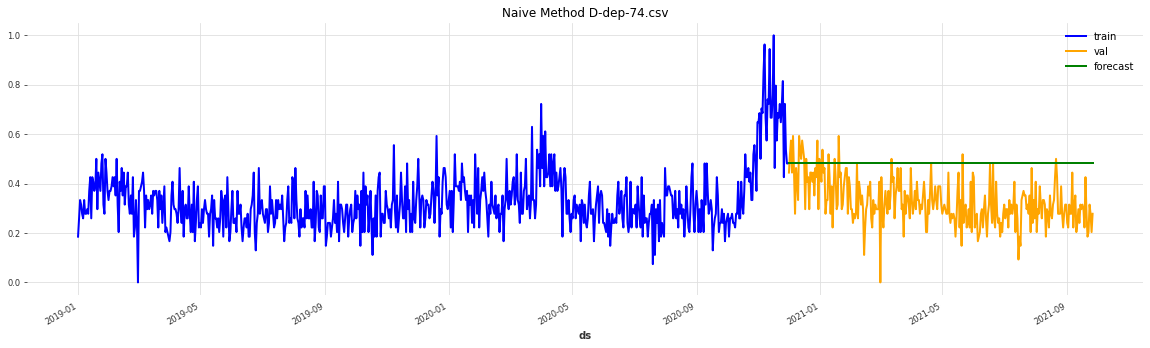

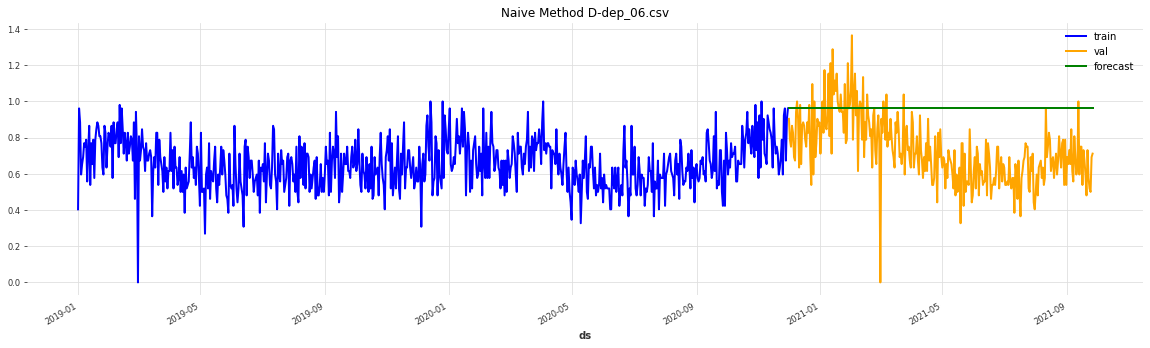

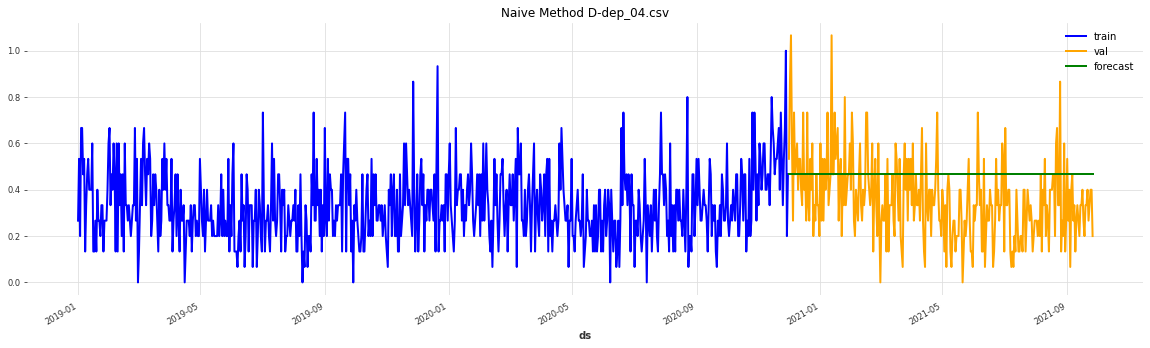

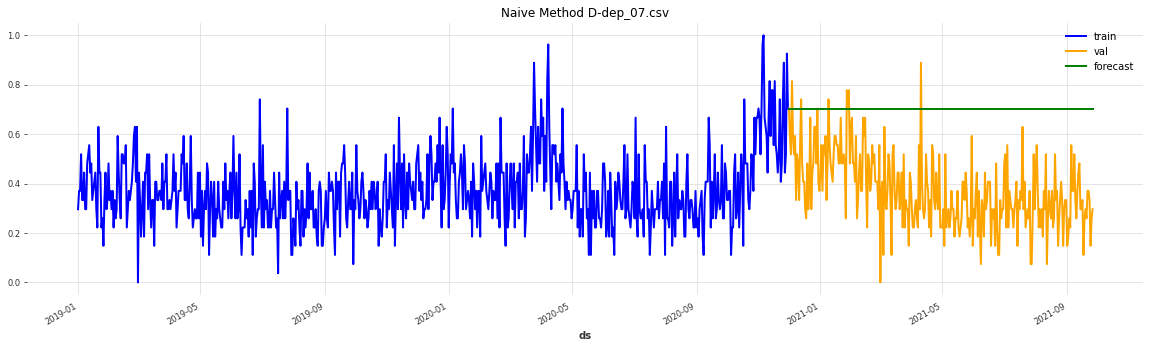

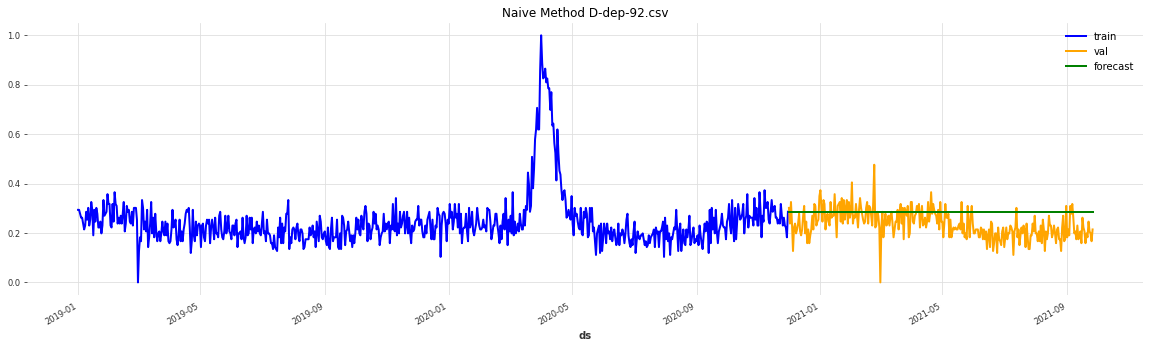

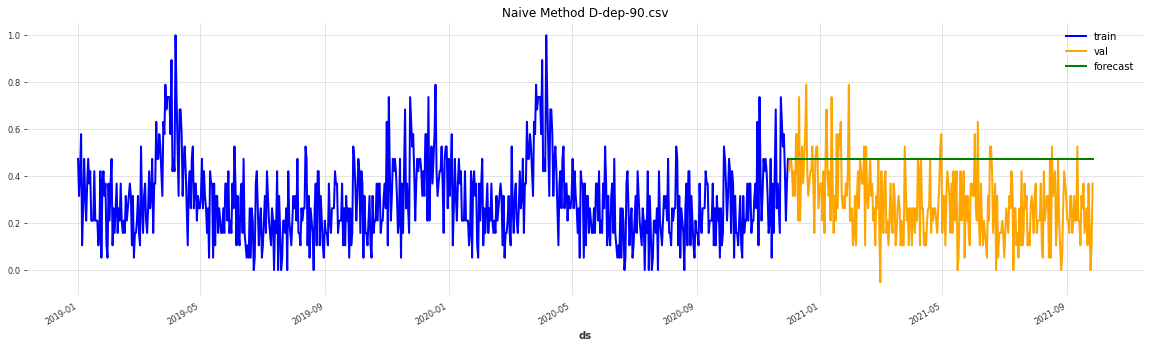

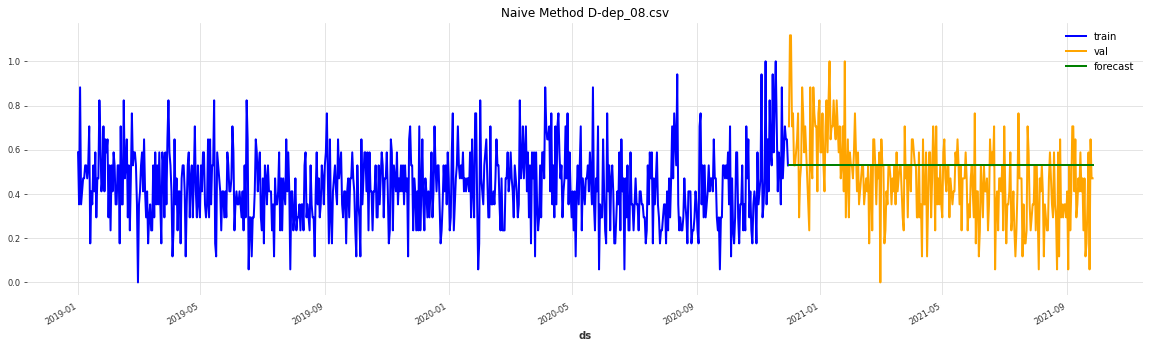

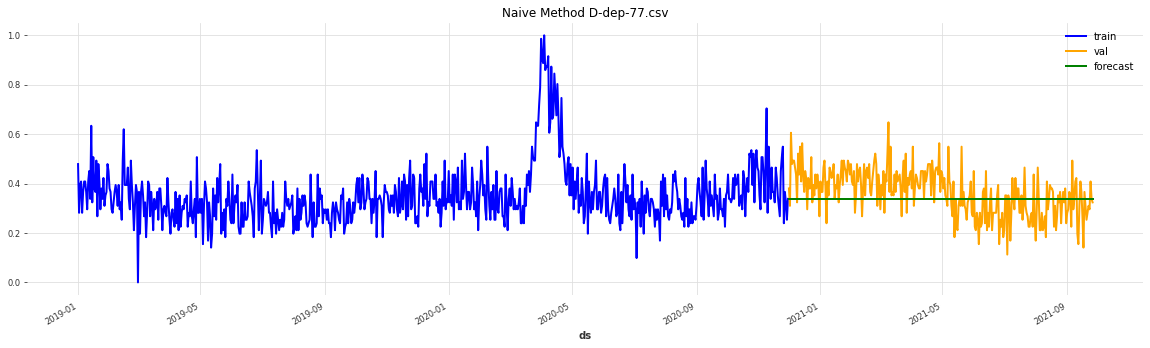

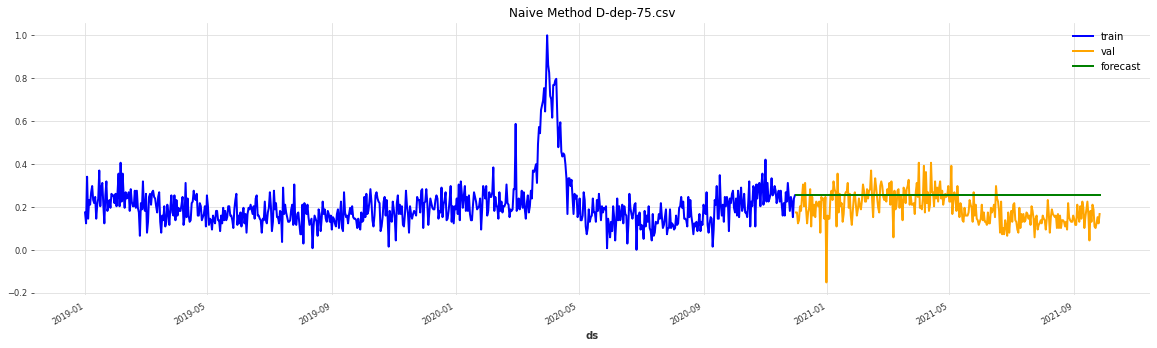

In [17]:
for i in range(len(df_fit_naive)):
    plt.figure(figsize=(20,5))
    df_fit_naive[i].plot(color ='blue', label="train")
    df_true_prediction_naive[i].plot(color ='orange', label="val")
    forecast_naive[i].plot(color ='green',label="forecast")
    plt.title('Naive Method '+file_name[i]+".csv")    
    plt.legend(loc='best')
    plt.show()

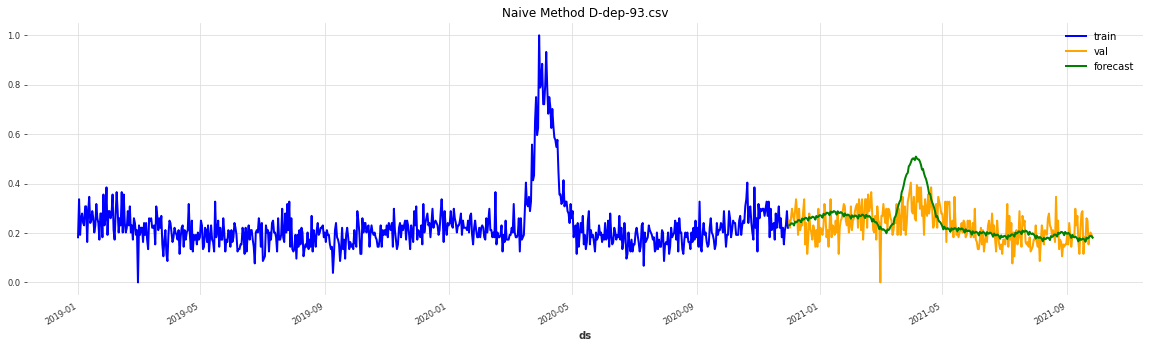

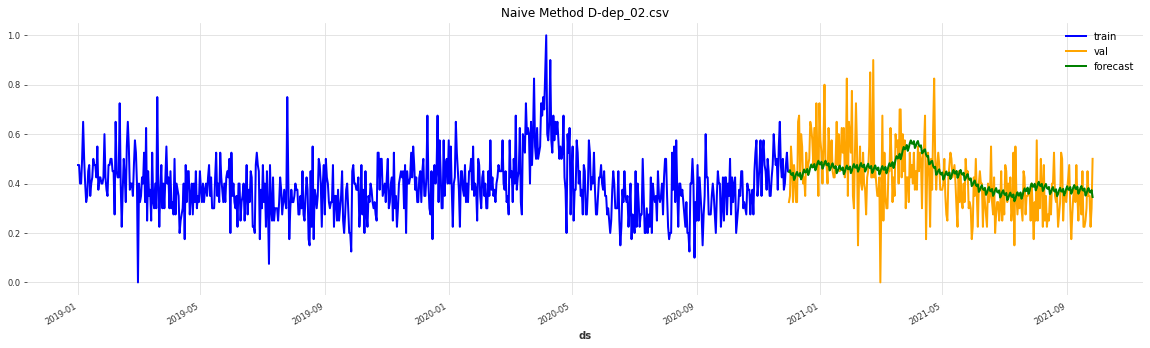

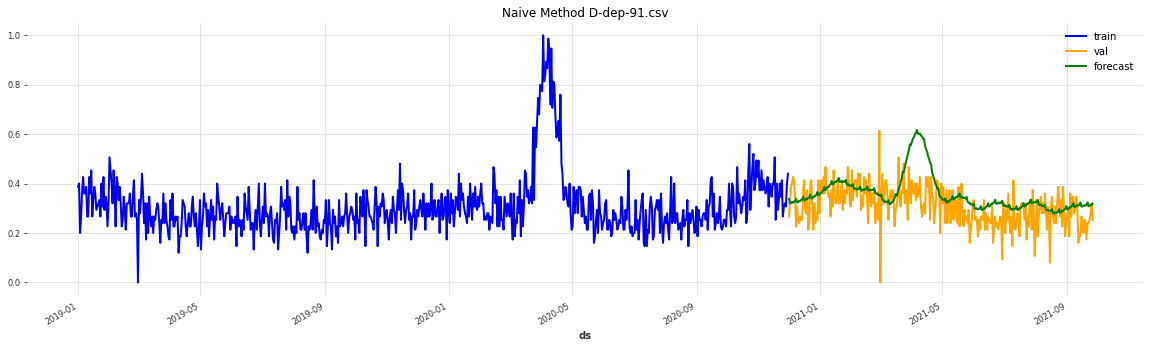

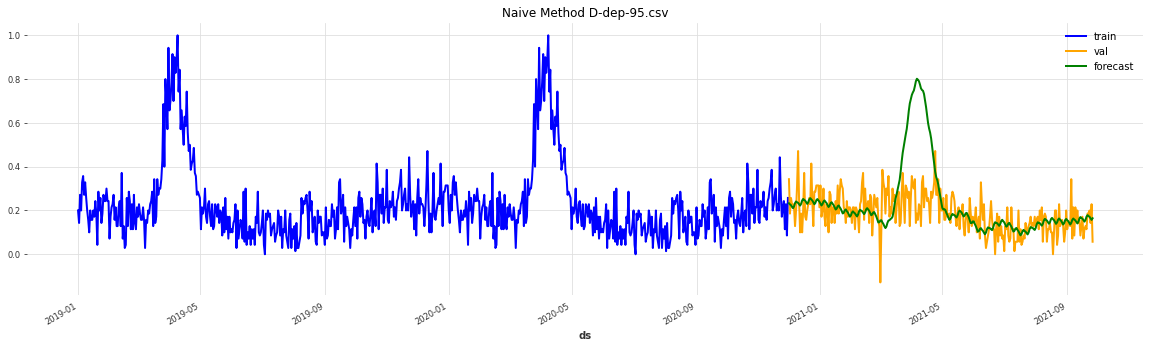

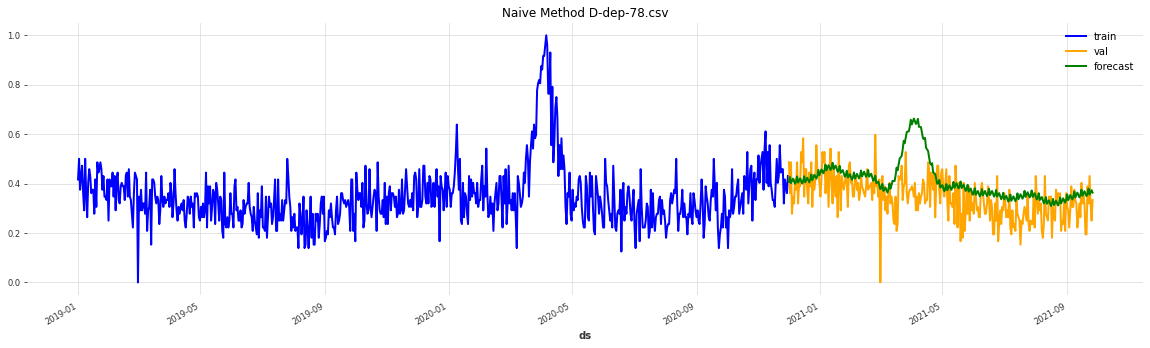

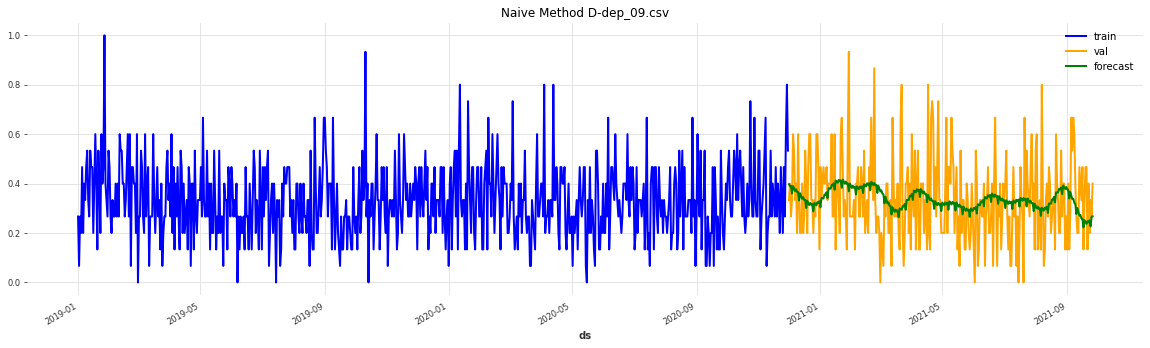

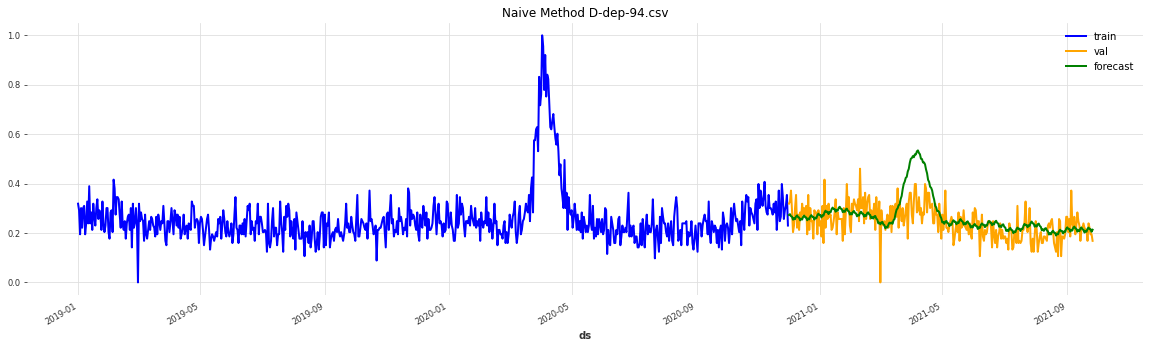

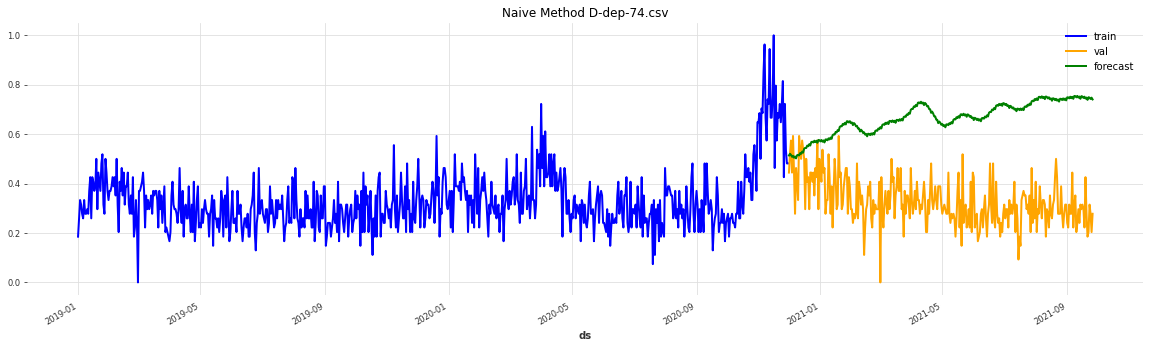

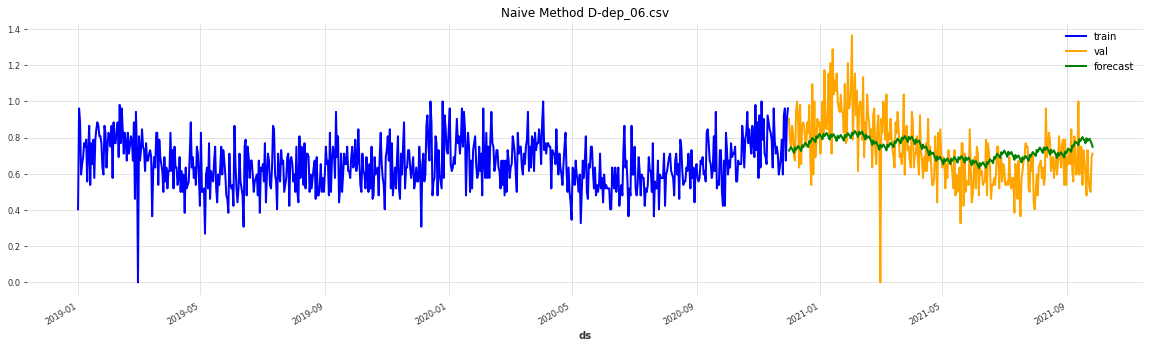

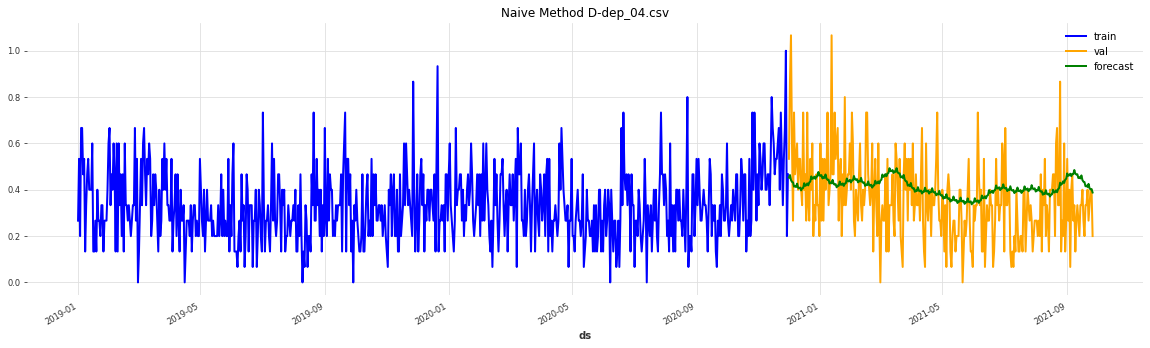

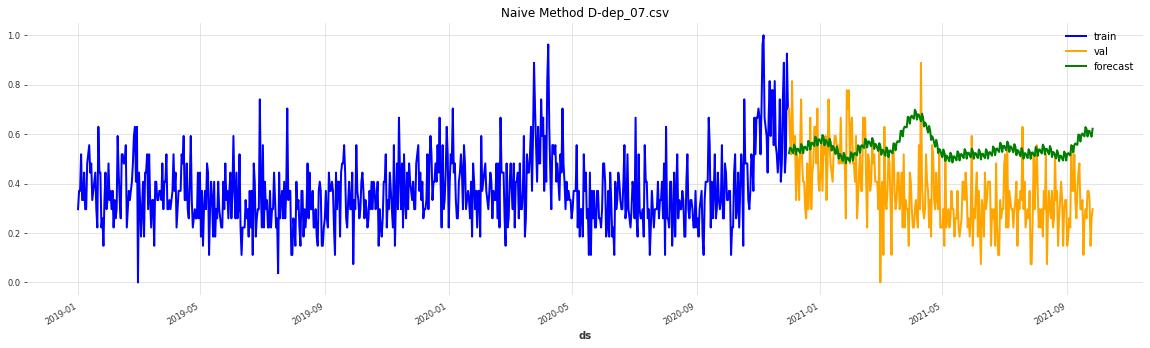

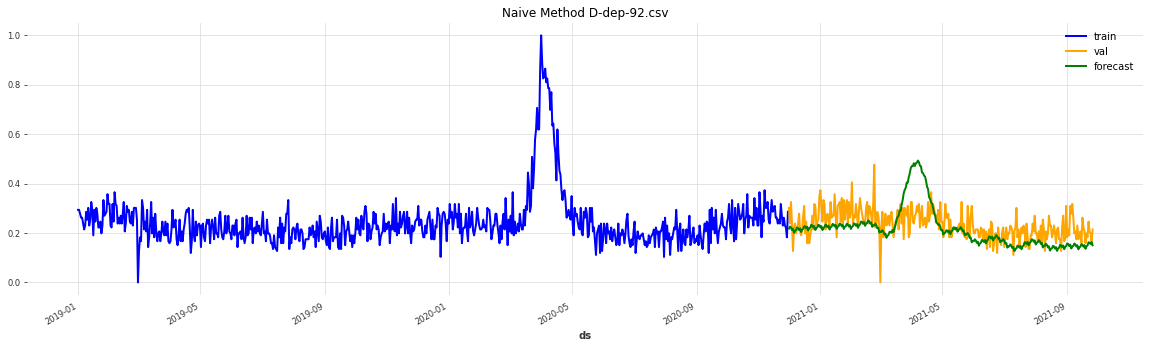

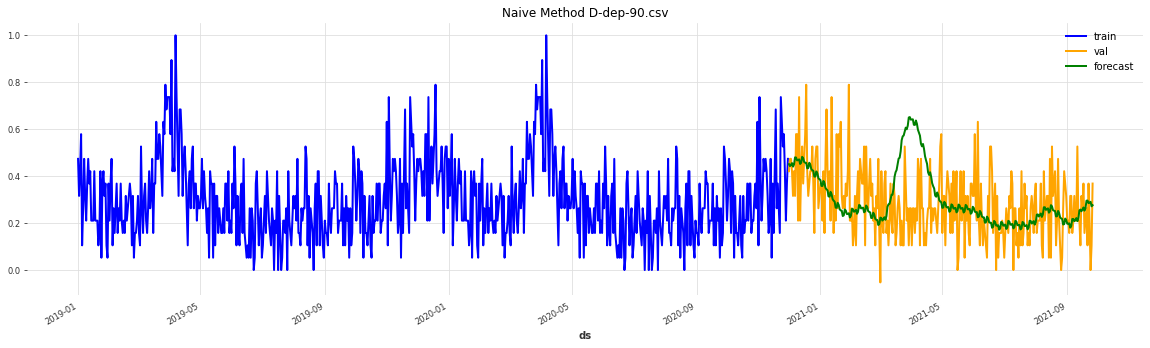

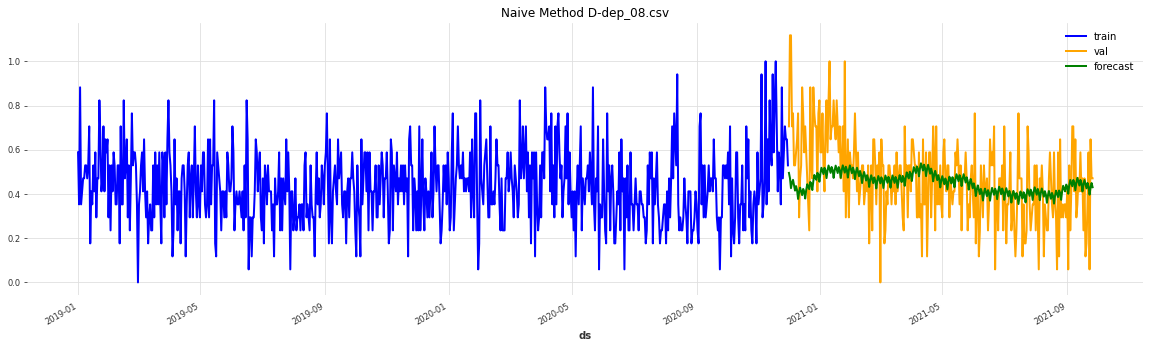

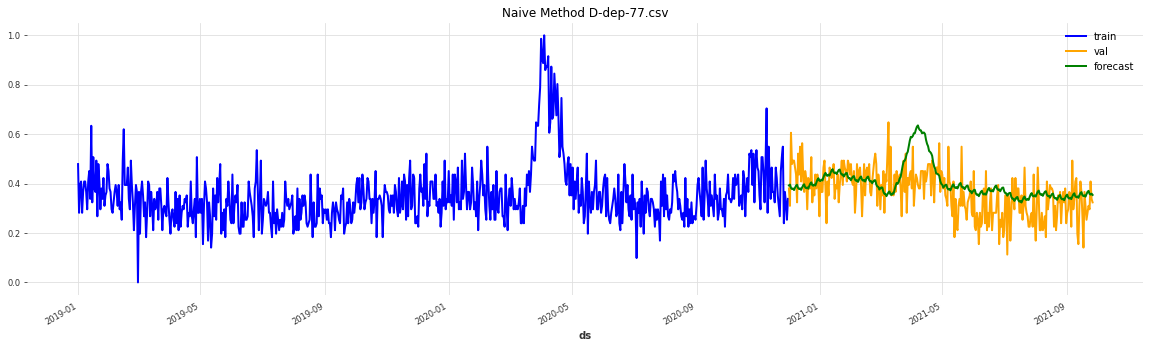

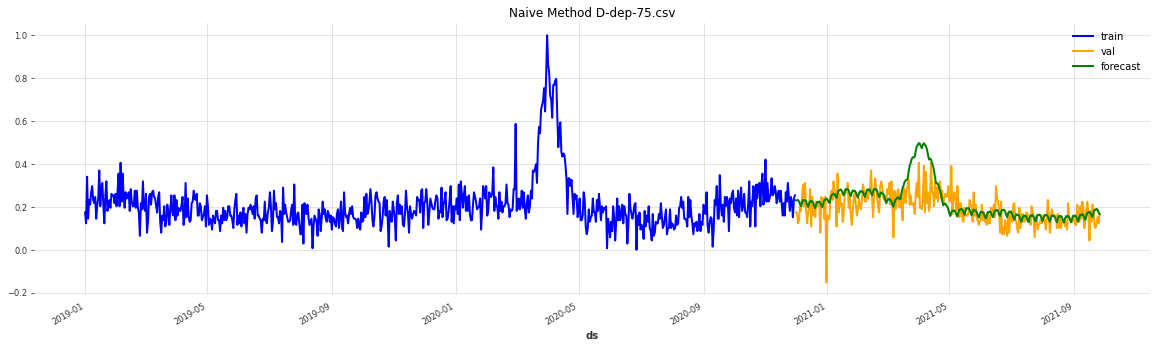

In [18]:
for i in range(len(df_fit_prophet)):
    plt.figure(figsize=(20,5))
    df_fit_prophet[i].plot(color ='blue', label="train")
    df_true_prediction_prophet[i].plot(color ='orange', label="val")
    forecast_prophet[i].plot(color ='green',label="forecast")
    plt.title('Naive Method '+file_name[i]+".csv")    
    plt.legend(loc='best')
    plt.show()

In [19]:
for i in range(len(df_fit_naive)):
    if len(df_fit_naive[i]) != 700 :
        print("ERROR, len(df_fit_naive[{}] = ".format(i, len(df_fit_naive[i])))
    elif len(df_true_prediction_naive[i]) != 300 :
        print("ERROR, len(df_true_prediction_naive[{}] = ".format(i, len(df_true_prediction_naive[i])))
    else:
        print("Tout est bon pour data i = ", i)
    print("-----")

Tout est bon pour data i =  0
-----
Tout est bon pour data i =  1
-----
Tout est bon pour data i =  2
-----
Tout est bon pour data i =  3
-----
Tout est bon pour data i =  4
-----
Tout est bon pour data i =  5
-----
Tout est bon pour data i =  6
-----
Tout est bon pour data i =  7
-----
Tout est bon pour data i =  8
-----
Tout est bon pour data i =  9
-----
Tout est bon pour data i =  10
-----
Tout est bon pour data i =  11
-----
Tout est bon pour data i =  12
-----
Tout est bon pour data i =  13
-----
Tout est bon pour data i =  14
-----
Tout est bon pour data i =  15
-----


In [20]:
for i in range(len(df_fit_prophet)):
    if len(df_fit_prophet[i]) != 700 :
        print("ERROR, len(df_fit_prophet[{}] = ".format(i, len(df_fit_prophet[i])))
    elif len(df_true_prediction_prophet[i]) != 300 :
        print("ERROR, len(df_true_prediction_prophet[{}] = ".format(i, len(df_true_prediction_prophet[i])))
    else:
        print("Tout est bon pour data i = ", i)
    print("-----")

Tout est bon pour data i =  0
-----
Tout est bon pour data i =  1
-----
Tout est bon pour data i =  2
-----
Tout est bon pour data i =  3
-----
Tout est bon pour data i =  4
-----
Tout est bon pour data i =  5
-----
Tout est bon pour data i =  6
-----
Tout est bon pour data i =  7
-----
Tout est bon pour data i =  8
-----
Tout est bon pour data i =  9
-----
Tout est bon pour data i =  10
-----
Tout est bon pour data i =  11
-----
Tout est bon pour data i =  12
-----
Tout est bon pour data i =  13
-----
Tout est bon pour data i =  14
-----
Tout est bon pour data i =  15
-----
